In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/tweet_csv/ann/221218_ann.csv"
df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.drop('tweet_id', axis=1)
df = df.drop('author_id', axis=1)
df = df.drop('username', axis=1)
df = df.drop('like_count', axis=1)
df = df.drop('retweet_count', axis=1)
df

,created_at,text
0,2022-12-18 01:00:00,#annkw
1,2022-12-18 01:00:00,今年最後のひとつよしなに #annkw
2,2022-12-18 01:00:00,#annkw
3,2022-12-18 01:00:00,#annkw
4,2022-12-18 01:00:00,#annkw
...,...,...
6524,2022-12-18 03:04:47,また来年！ミッフィーちゃん！アディオス！ #annkw
6525,2022-12-18 03:04:49,あでぃおす #annkw
6526,2022-12-18 03:04:50,スカシ芸人🤣🤣👏👏 #annkw
6527,2022-12-18 03:04:50,キューバ本のときのインタビュアーと再会した若林、BSの番組、若林の街ブラ、関東スカシ芸人パー...


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[()]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(u'[■♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、│/`:@`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(u"[`']", '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2022-12-18 01:00:00,
1,2022-12-18 01:00:00,今年最後のひとつよしなに
2,2022-12-18 01:00:00,
3,2022-12-18 01:00:00,
4,2022-12-18 01:00:00,
...,...,...
6524,2022-12-18 03:04:47,また来年ミッフィーちゃんアディオス
6525,2022-12-18 03:04:49,あでぃおす
6526,2022-12-18 03:04:50,スカシ芸人
6527,2022-12-18 03:04:50,キューバ本のときのインタビュアーと再会した若林bsの番組若林の街ブラ関東スカシ芸人パーソナリ...


In [4]:
df.to_csv('preprocessed.csv', index=False)

In [5]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# stopwords += ["w", "ww", "www", "wwww", "wwwww", "笑",
#               "の", "し", "さ", "て", "れ", "ない", "てる",]

In [6]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
    #     filtered_words = [
    #         word for word in sentence_words if word not in stopwords]
    # return filtered_words
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2022-12-18 01:00:00,,0
1,2022-12-18 01:00:00,今年最後のひとつよしなに,"[今年, 最後, ひとつ, よしなに]"
2,2022-12-18 01:00:00,,0
3,2022-12-18 01:00:00,,0
4,2022-12-18 01:00:00,,0
...,...,...,...
6524,2022-12-18 03:04:47,また来年ミッフィーちゃんアディオス,"[来年, ミッフィー, ちゃん, アディオス]"
6525,2022-12-18 03:04:49,あでぃおす,[ぃおす]
6526,2022-12-18 03:04:50,スカシ芸人,"[スカシ, 芸人]"
6527,2022-12-18 03:04:50,キューバ本のときのインタビュアーと再会した若林bsの番組若林の街ブラ関東スカシ芸人パーソナリ...,"[キューバ, 本, とき, インタビュアー, 再会, し, 若林, bs, 番組, 若林, ..."


In [7]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2022-12-18 01:00:00,"[今年, 最後, ひとつ, よしなに, ニチレイプレゼンツ, 温泉, joar, なう, ひ..."
1,2022-12-18 01:01:00,"[今年, ラスト, ひとつ, よしなに, 0, 年, 最後, 放送, 来週, ミュージックソ..."
2,2022-12-18 01:02:00,"[アバトゥース, 0, years, after, 今年, 最後, ひと, よし, めんどく..."
3,2022-12-18 01:03:00,"[今年, どう, 面倒くさい, w, 若, 聞く, こと, ない, 聞い, てる, ん, 春..."
4,2022-12-18 01:04:00,"[そんなに, ストレス, 溜まっ, て, の, 午前0時, 焼肉, 食っ, て, 死ん, で..."
...,...,...
120,2022-12-18 03:00:00,"[来年, オブ, ミッフィー, ちゃん, 今年, 0, 年, 動き, ある, の, 今年, ..."
121,2022-12-18 03:01:00,"[あやのん, 明日, 櫻, 坂, 0, いのり, 天, こち星, 来週, 水曜, 乃木坂, ..."
122,2022-12-18 03:02:00,"[0, 週間, ない, の, 辛い, 次, 来年, 楽しみ, し, ミッフィー, ちゃん, ..."
123,2022-12-18 03:03:00,"[年内, ラスト, 疲れ, し, 少し, 早い, lt, 皆さま, 良いお年を, 来年, 深..."


In [8]:
# df_words.to_csv('words.csv', index=False)

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf').generate(' '.join(words))
        plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f"{index+1}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
120    None
121    None
122    None
123    None
124    None
Length: 125, dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df = df.drop("words", axis=1)
df


,created_at,vector
0,2022-12-18 01:00:00,0
1,2022-12-18 01:00:00,"[0.6888564, -0.91577977, 0.0735086, 1.7833742,..."
2,2022-12-18 01:00:00,0
3,2022-12-18 01:00:00,0
4,2022-12-18 01:00:00,0
...,...,...
6524,2022-12-18 03:04:47,"[0.18347803, -0.41155395, 0.82340145, 0.285667..."
6525,2022-12-18 03:04:49,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6526,2022-12-18 03:04:50,"[0.3057899, -0.57138574, 0.2583511, -0.1928725..."
6527,2022-12-18 03:04:50,"[0.102628894, 0.3114791, 0.051228378, -0.30631..."


In [11]:
df.to_csv('vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2022-12-18 01:00:00,"[0, [0.6888564, -0.91577977, 0.0735086, 1.7833..."
1,2022-12-18 01:01:00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2022-12-18 01:02:00,"[0, [-1.1277126, 0.13423617, -0.41325605, 0.64..."
3,2022-12-18 01:03:00,"[[-0.13261823, 0.7418625, -0.740517, -0.378721..."
4,2022-12-18 01:04:00,"[[-0.5372986, -0.08793099, -0.46010256, -1.646..."
...,...,...
120,2022-12-18 03:00:00,"[[2.3948445, -2.213376, 0.27822614, 2.517096, ..."
121,2022-12-18 03:01:00,"[[0.042975232, 0.26233876, 0.046350237, 0.2468..."
122,2022-12-18 03:02:00,"[[-1.5525993, 0.8337089, -0.97142917, -0.26533..."
123,2022-12-18 03:03:00,"[[0.3909035, -0.5046043, -0.32784805, -0.21563..."


In [13]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [14]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2022-12-18 01:00:00,0.039710,0.227721,0.567195,0.323920,0.329953
1,2022-12-18 01:01:00,0.061914,0.222903,0.521357,0.303266,0.294753
2,2022-12-18 01:02:00,0.068358,0.225257,0.427764,0.269907,0.253534
3,2022-12-18 01:03:00,0.128158,0.230454,0.349402,0.249288,0.176691
4,2022-12-18 01:04:00,0.100359,0.205173,0.368037,0.262385,0.227327
...,...,...,...,...,...,...
120,2022-12-18 03:00:00,0.283839,0.499031,0.660021,0.494340,0.259058
121,2022-12-18 03:01:00,0.381294,0.500535,0.615644,0.486621,0.189883
122,2022-12-18 03:02:00,0.307080,0.438079,0.572161,0.448443,0.189723
123,2022-12-18 03:03:00,0.267439,0.464922,0.669284,0.469632,0.244533


In [15]:
df_vectors.to_csv('similarity.csv', index=False)


In [16]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/word2vec/221218_ann/count_all.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60 +1)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,1,0.039710,0.227721,0.567195,0.323920,0.329953,599
1,2,0.061914,0.222903,0.521357,0.303266,0.294753,285
2,3,0.068358,0.225257,0.427764,0.269907,0.253534,154
3,4,0.128158,0.230454,0.349402,0.249288,0.176691,101
4,5,0.100359,0.205173,0.368037,0.262385,0.227327,107
...,...,...,...,...,...,...,...
120,121,0.283839,0.499031,0.660021,0.494340,0.259058,69
121,122,0.381294,0.500535,0.615644,0.486621,0.189883,32
122,123,0.307080,0.438079,0.572161,0.448443,0.189723,21
123,124,0.267439,0.464922,0.669284,0.469632,0.244533,10


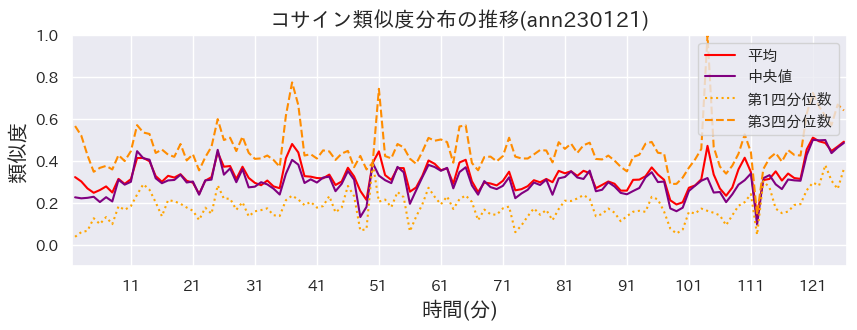

In [17]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "コサイン類似度分布の推移(ann230121)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows+0.5)
    ax.set_ylim(-0.1, 1)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    plt.savefig('quantile.png')


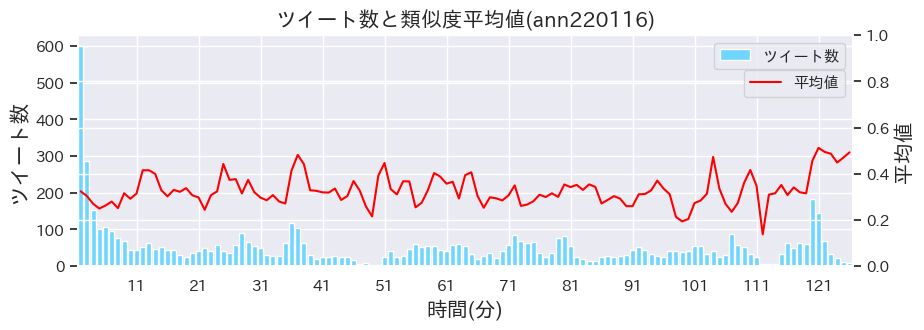

In [18]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    # df_vectors['stdev'] = df_vectors['stdev'].rolling(
    #     window=window, min_periods=1).mean()
    # df_vectors['alpha_m'] = df_vectors['mean'] - df_vectors['stdev']
    # df_vectors['alpha_p'] = df_vectors['mean'] + df_vectors['stdev']

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "ツイート数と類似度平均値(ann220116)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均値", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red", label="平均値")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_m"], color="orange", linestyle="dashed")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_p"], color="orange", linestyle="dashed",label="68%信頼区間")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.88))
    plt.savefig('mean.png')


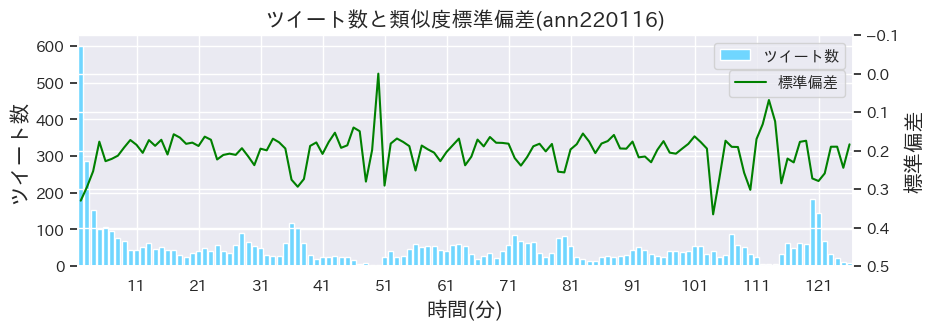

In [19]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "ツイート数と類似度標準偏差(ann220116)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.5, -0.1)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.88))
    plt.savefig('stdev.png')
